In [11]:
import wfdb
import numpy as np
import os
import pandas as pd
from random import randint
import math
import h5py
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from collections import Counter

In [12]:
def print_object_attributes(obj): #https://stackoverflow.com/questions/192109/is-there-a-built-in-function-to-print-all-the-current-properties-and-values-of-a
    for attr in dir(obj):
        print("obj.%s = %r" % (attr, getattr(obj, attr)))

### Read MIT format .dat ecg data files and .hea headers

In [13]:
BASE_DIR = '/media/julian/Volume/data/ECG/mit-bih-arrhythmia-database-1.0.0/' #Arrhythmia
#BASE_DIR = '/media/julian/Volume/data/ECG/ptb-diagnostic-ecg-database-1.0.0/'
READ_ANNOTATIONS = True
def get_file_list(BASE_DIR):
    record_files = []
    #file_endings = ['.dat', '.hea', '.xyz']
    with open(os.path.join(BASE_DIR, 'RECORDS')) as recs:
        record_files = recs.read().splitlines()
        recs.close()
    return record_files
record_files = get_file_list(BASE_DIR)
print(len(record_files))
print(record_files)

48
['100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '111', '112', '113', '114', '115', '116', '117', '118', '119', '121', '122', '123', '124', '200', '201', '202', '203', '205', '207', '208', '209', '210', '212', '213', '214', '215', '217', '219', '220', '221', '222', '223', '228', '230', '231', '232', '233', '234']


### Extract signal from *.dat files & Read annotations & Read comments

In [14]:
def read_comment(record_path):
    record = wfdb.rdrecord(record_path)
    return record.comments

In [15]:
def read_signal(record_path, physical=True):
    #print(record_path)
    record = wfdb.rdrecord(record_path, physical=physical)
    #print_object_attributes(record)
    if physical:
        data = record.p_signal
    else:
        data = record.d_signal
    return data

In [16]:
def read_annotation(record_path, physical=True, return_label_elements=['symbol', 'label_store', 'description']):
    try:
        annotation = wfdb.rdann(record_path, 'atr', return_label_elements=return_label_elements)
        #print(record_path)
        #print('sample:', annotation.sample, 'symbol', annotation.symbol, 'contained labels', annotation.description)
        return (annotation.sample, annotation.symbol, annotation.label_store, annotation.description)
    except ValueError as ve:
        print(record_path, ' annotation read failed:', ve)
        return None
    
def read_annotation_object(record_path, physical=True, return_label_elements=['symbol', 'label_store', 'description']):
    try:
        annotation = wfdb.rdann(record_path, 'atr', return_label_elements=return_label_elements)
        return annotation
    except ValueError as ve:
        print(record_path, ' annotation read failed:', ve)
        return None

In [17]:
def read_record_infos(record_path):
    record = wfdb.rdrecord(record_path)
    return {
        'record_name' : record.record_name,
        'file_name' : record.file_name,
        'record_comments' : record.comments,
        'number_of_signals' : record.n_sig,
        'is_physical_signal' : not (record.p_signal is None),
        'is_digital_signal' : not (record.d_signal is None),
        'signal_sampling_frequency' : record.fs,
        'signal_length' : record.sig_len,
        'signal_channel_names' : record.sig_name,
        'signal_channel_units' : record.units
    }   

In [63]:
def plot_record(record_path, index_from, index_to, channels=None):
    data = read_signal(record_path)
    annotation = read_annotation(record_path)
    if annotation:
        ann_index = 0
        while annotation[0][ann_index] < index_from:
            ann_index+=1
        ann_index_to = ann_index - 1
        while annotation[0][ann_index_to] < index_to:
            ann_index_to+=1
        for i in range(ann_index, ann_index_to):
            plt.annotate(annotation[1][i], (annotation[0][i], data[annotation[0][i], 0]))
    if channels is None or channels is []:
        plt.plot(np.arange(index_from, index_to), data[index_from:index_to, :])
    else:
        plt.plot(np.arange(index_from, index_to), data[index_from:index_to, channels])
    plt.show

In [ ]:
def save_to_h5(record_path):
    if not os.path.exists(storage_path):
        os.makedirs(storage_path)
    for f in dat_file_paths:
        data = read_signal(os.path.join(BASE_DIR, f))
        print(f)
        target = os.path.join(storage_path, f.replace('/', '-') +'.h5')
        with h5py.File(target, 'w') as wf:
            wf['windows'] = partitioned
            wf.flush()
            if verbose: print(target, 'file created and written. %d windows saved.' % (len(partitioned)))

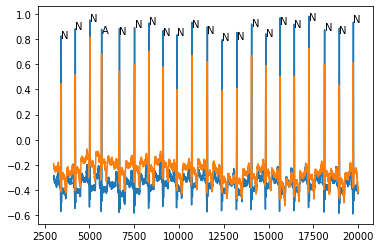

In [68]:
plot_record(os.path.join(BASE_DIR,record_files[0]), 3000, 20000, channels=None)

In [18]:
def partition_data(data, window_size=360*10, overlap=1.0, store_in_array=True, align_right=True, normalize_windows=False, mirror_data=False, verbose=True): #maybe allow non float overlap too
    samples, channels = data.shape
    if samples < window_size:
        print('too few samples (%d) to support window size of %d' % (samples, window_size))
        return None    
    if verbose: print('Input data has shape:', data.shape)
    shift = window_size*overlap
    offset = int(samples % shift)
    if align_right:
        used_data = data[offset:]
    else:
        used_data = data[:-offset]
    samples, _ = used_data.shape
    if mirror_data:
        used_data = np.flip(used_data)
        #used_data *= -1
    if verbose: print('The window of size %d will be shifted by %f. The total data used is %d' % (window_size, shift, samples))
    partitioned = np.empty((int(samples/shift)-1, window_size, channels))
    if verbose: print('The partitioned data now has shape:', partitioned.shape)
    for i in range(len(partitioned)):
        index = int(i*shift)
        partitioned[i, :, :] = used_data[index:index+window_size, :]
    if normalize_windows:
        partitioned = (partitioned-np.amin(partitioned, axis=1)[:, None])/(np.amax(partitioned, axis=1)-np.amin(partitioned, axis=1))[:, None]
    return partitioned, offset

In [19]:
def extract_ecg_beat(record_path, annotation_data=None, channel_index=0, threshold=0.9, window_sampling_duration_in_seconds=10, fixed_window_datapoints=1440, verbose=True): #https://arxiv.org/pdf/1805.00794.pdf methodolgy
    infos = read_record_infos(record_path)
    signal_data = read_signal(record_path)
    if annotation_data:
        timestamps, _, label, _ = annotation_data
    beat_data = []
#     if fixed_window_datapoints is None:
#         fixed_window_datapoints = infos['signal_sampling_frequency']*60/28 #https://de.wikipedia.org/wiki/Herzfrequenz lowest bpm = 28
    partioned_data, offset = partition_data(signal_data, infos['signal_sampling_frequency']*window_sampling_duration_in_seconds, verbose=verbose, mirror_data=False, normalize_windows=True) #1+2)
    total_peaks = total_failed = 0
    label_index = 0
    for frame_index in range(len(partioned_data)):
        frame = partioned_data[frame_index]
        channel = frame[:, channel_index] #channel_index is the 'main' channel
        peaks, _ = find_peaks(channel, distance=int(infos['signal_sampling_frequency']/10)) #3) #Distance parameter selected arbitrary to remove peaks right next to eachother
        threshold_peaks = peaks[channel[peaks]>threshold] #4)
        if len(threshold_peaks) > 1:              
            median_RR_interval = np.median((np.roll(threshold_peaks, -1) - threshold_peaks)[:-1]) #5
            beat_length = int(1.2 * median_RR_interval) #6)

            if verbose:
                plt.plot(channel)
                plt.plot(threshold_peaks, channel[threshold_peaks], "x")
                plt.plot(np.zeros_like(channel), "--", color="gray")
                plt.show()
                print(median_RR_interval)
            fails = 0
            for peak_index in threshold_peaks:
                peak_index_in_signal = offset+frame_index*len(frame)+peak_index
                if beat_length <= fixed_window_datapoints and peak_index_in_signal+beat_length<len(signal_data):
                    peak_data = signal_data[peak_index_in_signal:peak_index_in_signal+beat_length, :] #7)
                    peak_data = (peak_data-np.amin(peak_data, axis=0))/(np.amax(peak_data, axis=0)-np.amin(peak_data, axis=0)) #Normalize again! Not clear in paper!
                    peak_data = np.pad(peak_data, pad_width=((0, fixed_window_datapoints-beat_length), (0, 0)))
                    if annotation_data:
                        while timestamps[label_index+1] <= peak_index_in_signal:
                            label_index += 1
                        
                        if timestamps[label_index] <= peak_index_in_signal and peak_index_in_signal < timestamps[label_index+1]:
                            if verbose:
                                print(timestamps[label_index], '<=', peak_index_in_signal, '<', timestamps[label_index+1])
                                print(peak_index_in_signal, ' to ', label[label_index], 'with index:', label_index)
                            beat_data.append([peak_data, label[label_index]])
                            
                    else:
                        beat_data.append([peak_data, 0])
                    if verbose:
                        plt.plot(peak_data)
                        plt.show()
                else:
                    fails += 1
                    if verbose:
                        print("beat_length > fixed_window_datapoints:", 'median beat length:', median_RR_interval)
            if verbose:
                print(fails, 'of', len(threshold_peaks), 'failed')
            total_peaks += len(threshold_peaks)
            total_failed += fails
    print(total_failed, 'of', total_peaks, 'detected failed')
    if annotation_data:
        print("originally had", len(label), 'labels')
    return beat_data
            

### Save all extracted beats in a file

In [10]:
import h5py as h5
def write_h5_file(file_data, out_filepath):
    if not os.path.exists(os.path.dirname(out_filepath)):
        os.makedirs(os.path.dirname(out_filepath))
    print("Writing file:", out_filepath)
    all_beats = []
    all_labels = []
    with h5.File(out_filepath, 'w') as hdf_file:
        for f, _, b, _ in file_data:
            all_beats.append(np.stack([beat[0] for beat in b]))
            all_labels.append(np.stack([beat[1] for beat in b]))
        all_beats = np.concatenate(all_beats)
        all_labels = np.concatenate(all_labels)
        hdf_file.create_dataset('data', data=all_beats)
        hdf_file.create_dataset('label', data=all_labels)
        hdf_file.flush()
        hdf_file.close()
        

#### Save all signals and attributes in file_data (also note how many had functioning annotations)

In [ ]:
patients_in_file = 48 #Chose a number so that it fits into your ram. Higher ~ Bigger files
continue_index = 0
file_data = None

while continue_index < len(record_files):
    del file_data
    file_data = []
    success = 0
    for f in record_files[continue_index:continue_index+patients_in_file]:
        p = os.path.join(BASE_DIR, f)
        #print(read_record_infos(p))    
        d = read_signal(p, physical=True)
        a = None
        if READ_ANNOTATIONS:
            a = read_annotation(p, return_label_elements=['label_store'])
            c_before = Counter(a[2]) #index 2 = label_store
            print('label vorher:', c_before)
            #print(a)
        beats = extract_ecg_beat(p, annotation_data=a, threshold=0.8, verbose=False, channel_index=0, fixed_window_datapoints=2800)

        if not a is None:
            c_after = Counter([beat[1] for beat in beats])
            print('label automatisch extracted:', c_after)
            success += 1
            file_data.append((f, d, beats, a)) #Annotation/Labels available
        else:
            file_data.append((f, d, beats, None)) #only beat-candidates available
    
    out_filepath = os.path.join(BASE_DIR, 'generated/extracted-beats-patient-'+str(continue_index)+'-'+str(continue_index+patients_in_file)+'.h5')
    write_h5_file(file_data, out_filepath)
    continue_index += patients_in_file

if READ_ANNOTATIONS:
    print('%d of %d annotation reads succeeded.' % (success, len(record_files)))

# Plotting


NameError: name 'all_labels' is not defined

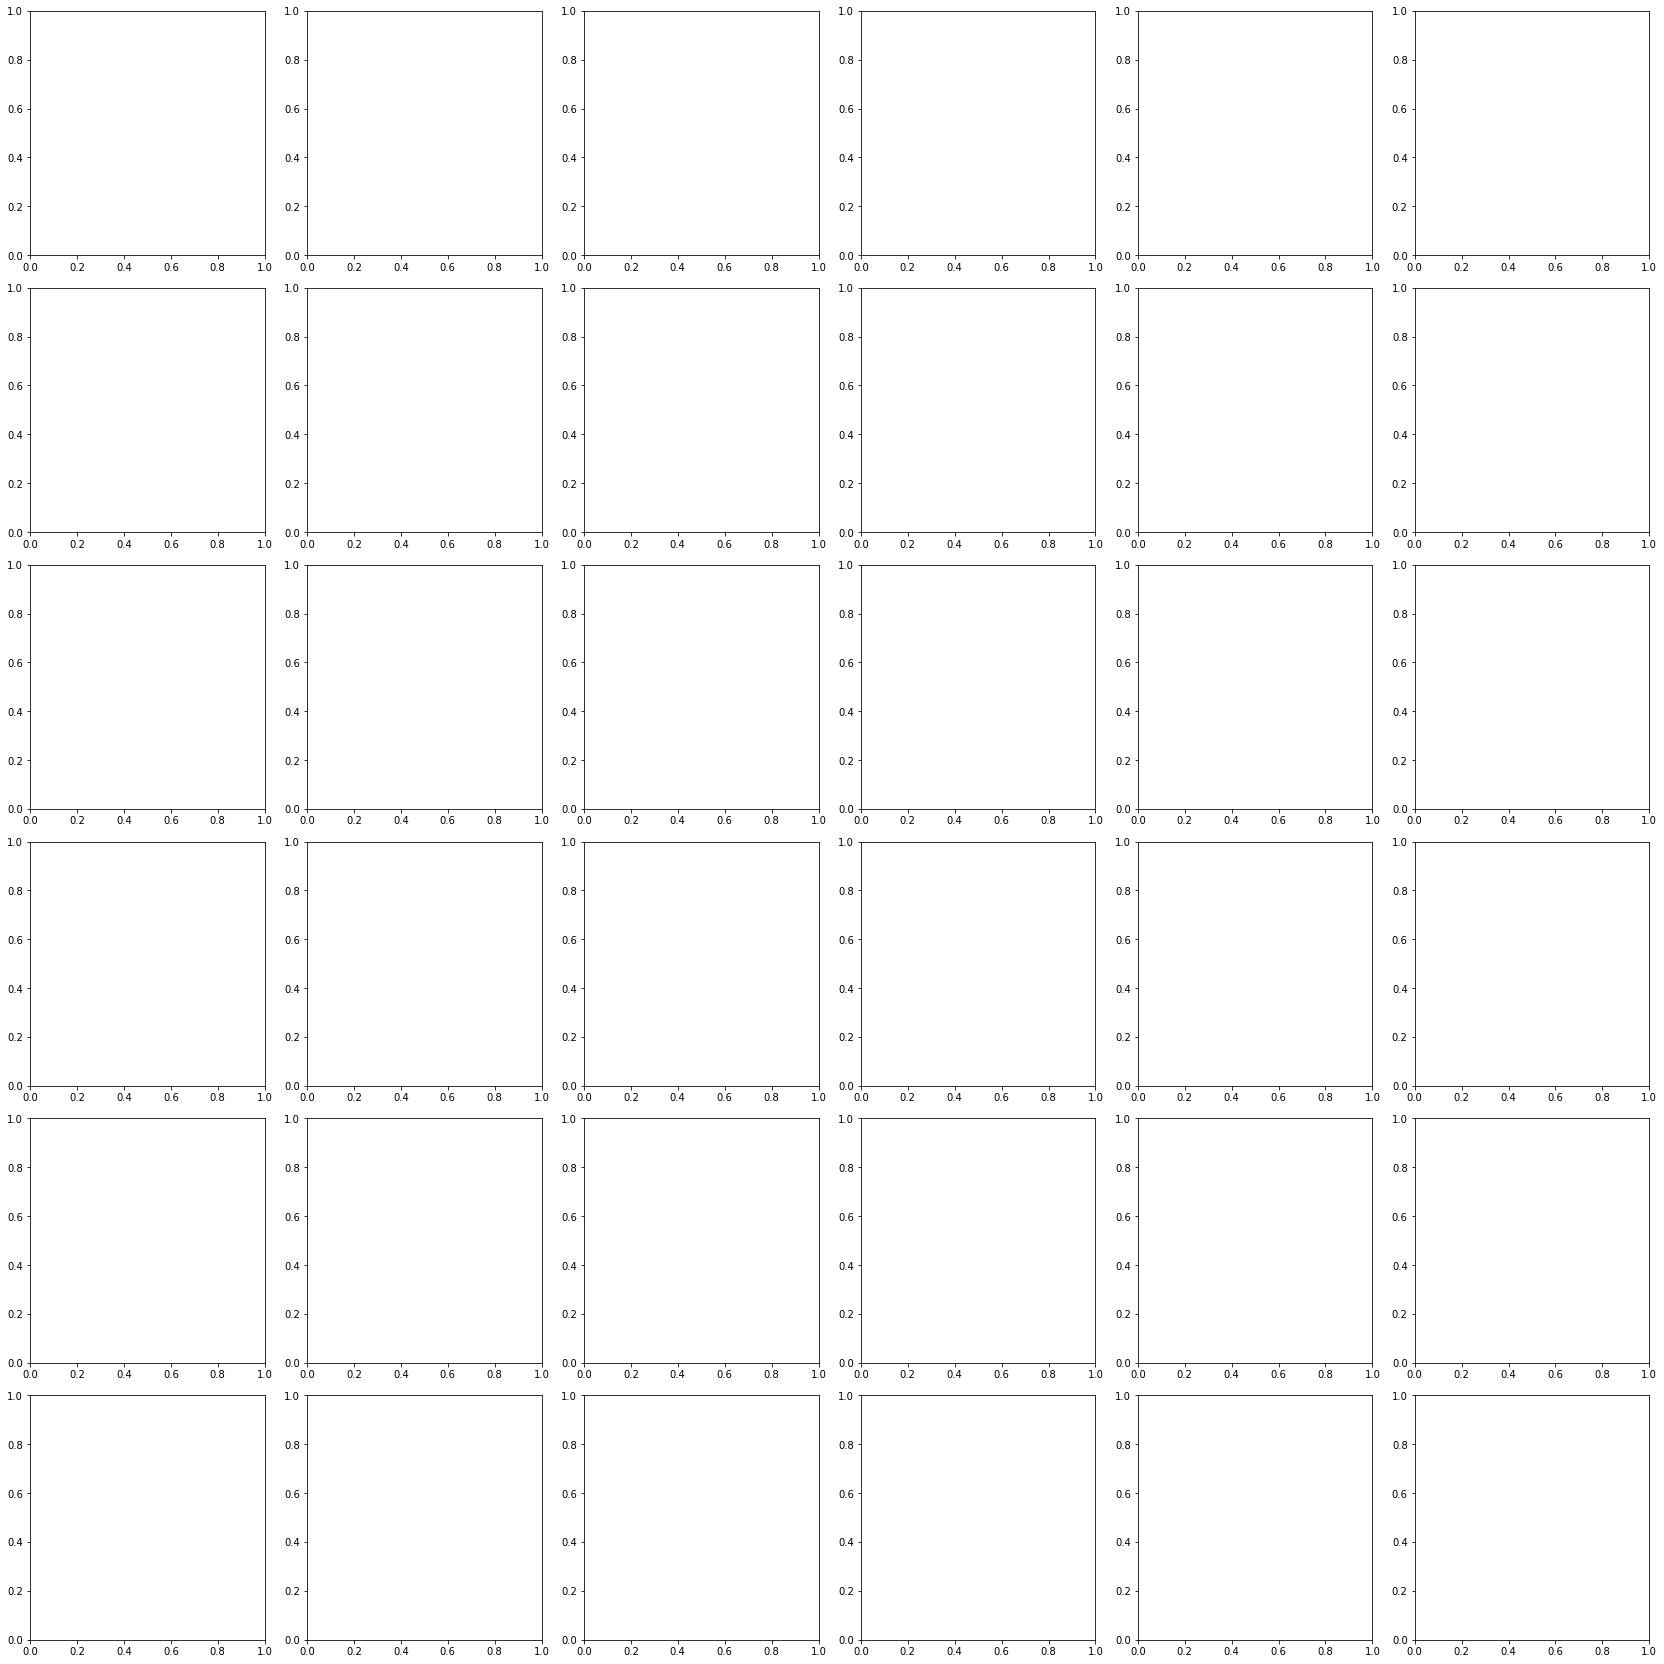

In [12]:
fig, axs = plt.subplots(nrows=6, ncols=6, constrained_layout=True, figsize=(23,23))
for ax in axs.flat:
    random_beat_index = randint(0, len(all_labels))
    ax.plot(all_beats[random_beat_index, :, 0])
    ax.set_title(all_labels[random_beat_index], fontsize=14)

In [ ]:
wfdb.show_ann_labels()

HDFViewer(children=(HDFViewer(children=(Accordion(children=(VBox(children=(HTML(value='<i>Dimension: (96862, 2…

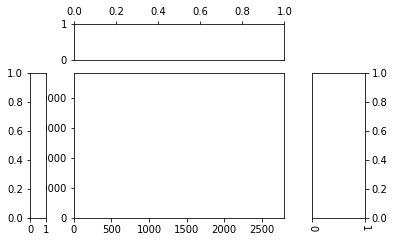

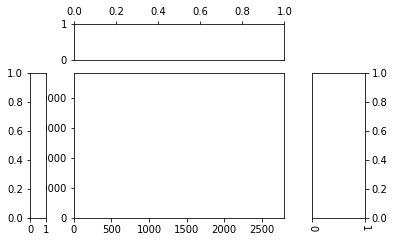

In [21]:
from hdfviewer.widgets.HDFViewer import HDFViewer

hdf5 = h5py.File('/media/julian/Volume/data/ECG/mit-bih-arrhythmia-database-1.0.0/generated/extracted-beats-patient-0-48.h5',"r")
display(HDFViewer(hdf5))

100 (650000, 2) 649991


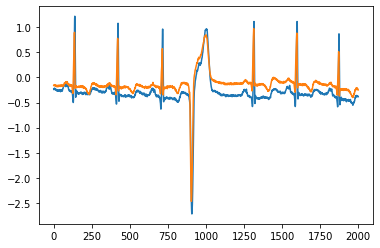

In [35]:

for f, d, a in file_data:
    if a:
        print(f, d.shape, max(a[0]))
    plt.plot(d[546885-1000:546885+1000])
    break

In [ ]:
patient0 = file_data[0]
data = patient0[1]
annotation = patient0[2]
timestamp, label_symbol, label_int, label_description = annotation

In [ ]:
plt.scatter(timestamp, label_symbol)
plt.show()

In [ ]:
plt.gca().invert_yaxis()
from_t, to_t = 360, 4000
plt.plot(np.arange(from_t, to_t, 1), data[from_t:to_t])
plt.show()

# Resample

In [2]:
from wfdb.processing import resample_multichan
import glob
import sys
import traceback
def resample_frequency(record_signal_array, annotation_object, hz_frq_in:int, hz_frq_out:int):
    return resample_multichan(record_signal_array, annotation_object, hz_frq_in, hz_frq_out, resamp_ann_chan=0)
    
def resample_frequency_all(record_files, hz_frq_out, output_filepath, physical=True, overwrite=False):
    print('Resamling of files has started:', record_files)
    if not os.path.exists(output_filepath):
        os.makedirs(output_filepath)
    for file in record_files:
        print("Resampling:", file)
        record_path = os.path.join(BASE_DIR, file)
        if overwrite or not glob.glob(output_filepath+file+'resampled.*'):
            file_infos = read_record_infos(record_path)
            print("read record infos")
            hz_frq_in = file_infos['signal_sampling_frequency']
            record_signal = read_signal(record_path, physical=physical)
            print("read record signal", record_signal.shape)
            annotation_object = read_annotation_object(record_path, physical=physical, return_label_elements=['symbol'])#, 'label_store']) cannot use, wfdb is buggy
            print("read record annotation")
            try:
                resampled_signal, resampled_ann = resample_frequency(record_signal, annotation_object, hz_frq_in, hz_frq_out) #Throws random assertionerrors at times
                print("computed resampled signal", resampled_signal.shape)
                #wfdb.wrann(file+"resampled", 'atr', sample=resampled_ann.sample, label_store=annotation_object.label_store, write_dir=output_filepath)
                a_temp = wfdb.Annotation(file+"resampled", 'atr', resampled_ann.sample, symbol=annotation_object.symbol, fs=hz_frq_out, label_store=annotation_object.label_store)
                a_temp.wrann(write_fs=True, write_dir=output_filepath)
                if physical:
                    wfdb.wrsamp(file+"resampled", fs=hz_frq_out, p_signal=resampled_signal, sig_name=file_infos['signal_channel_names'], units=file_infos['signal_channel_units'], comments=file_infos['record_comments'], write_dir=output_filepath)
                else:
                    wfdb.wrsamp(file+"resampled", fs=hz_frq_out, d_signal=resampled_signal, sig_name=file_infos['signal_channel_names'], units=file_infos['signal_channel_units'], comments=file_infos['record_comments'], write_dir=output_filepath)
                print('finished')
            except AssertionError: #https://stackoverflow.com/questions/11587223/how-to-handle-assertionerror-in-python-and-find-out-which-line-or-statement-it-o
                _, _, tb = sys.exc_info()
                traceback.print_tb(tb) # Fixed format
                tb_info = traceback.extract_tb(tb)
                filename, line, func, text = tb_info[-1]

                print('An error occurred on line {} in statement {}'.format(line, text))
            
        else:
          print("skipping", file)

In [ ]:
record_files = get_file_list(BASE_DIR)
resample_frequency_all(record_files, hz_frq_out=1000, output_filepath=os.path.join(BASE_DIR,'generated/resampled'))

Resamling of files has started: ['100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '111', '112', '113', '114', '115', '116', '117', '118', '119', '121', '122', '123', '124', '200', '201', '202', '203', '205', '207', '208', '209', '210', '212', '213', '214', '215', '217', '219', '220', '221', '222', '223', '228', '230', '231', '232', '233', '234']
Resampling: 100
read record infos
read record signal
read record annotation


## Read resampled data

In [21]:
BASE_DIR = '/media/julian/Volume/data/ECG/mit-bih-arrhythmia-database-1.0.0/generated/resampled/' #Arrhythmia
#BASE_DIR = '/media/julian/Volume/data/ECG/ptb-diagnostic-ecg-database-1.0.0/'
READ_ANNOTATIONS = True
def get_file_list(BASE_DIR):
    record_files = []
    #file_endings = ['.dat', '.hea', '.xyz']
    with open(os.path.join(BASE_DIR, 'RECORDS')) as recs:
        record_files = recs.read().splitlines()
        recs.close()
    return record_files
record_files = get_file_list(BASE_DIR)
print(len(record_files))
print(record_files)

41
['100resampled', '101resampled', '102resampled', '103resampled', '104resampled', '105resampled', '107resampled', '109resampled', '221resampled', '222resampled', '223resampled', '228resampled', '230resampled', '232resampled', '233resampled', '234resampled', '202resampled', '203resampled', '205resampled', '208resampled', '209resampled', '210resampled', '117resampled', '118resampled', '121resampled', '122resampled', '123resampled', '124resampled', '200resampled', '212resampled', '111resampled', '112resampled', '113resampled', '114resampled', '115resampled', '116resampled', '213resampled', '214resampled', '215resampled', '217resampled', '219resampled']


In [26]:
read_record_infos(os.path.join(BASE_DIR,record_files[0]))

{'record_name': '100resampled',
 'file_name': ['100resampled.dat', '100resampled.dat'],
 'record_comments': ['69 M 1085 1629 x1', 'Aldomet, Inderal'],
 'number_of_signals': 2,
 'is_physical_signal': True,
 'is_digital_signal': False,
 'signal_sampling_frequency': 1000,
 'signal_length': 1805555,
 'signal_channel_names': ['MLII', 'V5'],
 'signal_channel_units': ['mV', 'mV']}

ValueError: x and y can be no greater than 2-D, but have shapes (12000,) and (12000, 1, 2)

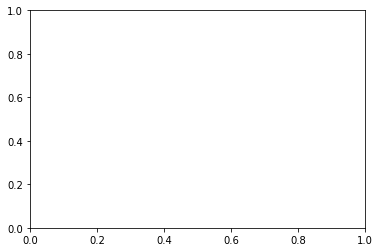

In [35]:
plot_record(os.path.join(BASE_DIR,record_files[0]), 3000, 15000)